In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)

T = 400
dt = 1e-3
time = jnp.arange(T) * dt

tau_m = 0.02         
R = 1.0               
V_rest = -0.07          
V0 = V_rest             
n_syn = 5               

key_master = jax.random.PRNGKey(0)


In [ ]:
def simulate_lif(w, I_basis, dt, tau_m, R, V_rest, V0):
    # total input current at each time: I(t) = sum_j w_j * I_basis(t,j)
    I_t = I_basis @ w   # shape (T,)

    def step(V, I):
        dVdt = (-(V - V_rest) + R * I) / tau_m
        V_new = V + dt * dVdt
        return V_new, V_new

    V_T, V_trace = jax.lax.scan(step, V0, I_t)
    return V_trace

# speed!
simulate_lif_jit = jax.jit(simulate_lif, static_argnums=(2,3,4,5,6))


In [11]:
def make_inputs(key, T, n_syn, padding=50):
    key_t = key
    # Avoid edges so we have room around spikes
    t_low = padding
    t_high = T - padding

    t_pre = jax.random.randint(key_t, (n_syn,), t_low, t_high)

    I_basis = jnp.zeros((T, n_syn))
    I_basis = I_basis.at[t_pre, jnp.arange(n_syn)].set(1.0)
    return I_basis, t_pre


In [12]:
# teacher
key_master, key_wtrue = jax.random.split(key_master)
w_true = jax.random.normal(key_wtrue, (n_syn,)) * 0.5

def loss_fn(w, I_basis, V_target, dt, tau_m, R, V_rest, V0):
    V = simulate_lif_jit(w, I_basis, dt, tau_m, R, V_rest, V0)
    return jnp.mean((V - V_target) ** 2)

# value_and_grad wrt synaptic weights
loss_and_grad_w = jax.value_and_grad(loss_fn, argnums=0)
loss_and_grad_w_jit = jax.jit(loss_and_grad_w, static_argnums=(3,4,5,6,7))


In [ ]:
def run_single_trial(key, w_true, dt, tau_m, R, V_rest, V0):
    key_inp, key_perturb = jax.random.split(key)
    I_basis, t_pre = make_inputs(key_inp, T, n_syn)
    V_target = simulate_lif_jit(w_true, I_basis, dt, tau_m, R, V_rest, V0)
    w_current = w_true + 0.1 * jax.random.normal(key_perturb, w_true.shape)

    loss_val, grad_w = loss_and_grad_w_jit(
        w_current, I_basis, V_target, dt, tau_m, R, V_rest, V0
    )

    V_current = simulate_lif_jit(w_current, I_basis, dt, tau_m, R, V_rest, V0)
    local_v = V_current[t_pre]   # shape (n_syn,)

    return {
        "I_basis": I_basis,
        "t_pre": t_pre,
        "V_target": V_target,
        "V_current": V_current,
        "w_current": w_current,
        "loss": loss_val,
        "grad_w": grad_w,
        "local_v": local_v,
    }


Loss: 2.3474630591326237e-06
Current weights: [-0.29832761 -0.0919668  -1.10981889  0.04498407  0.09904864]
Gradient dL/dw: [-1.70057925e-05 -8.96909928e-06 -1.41347922e-05  3.26524267e-07
 -1.54523643e-05]


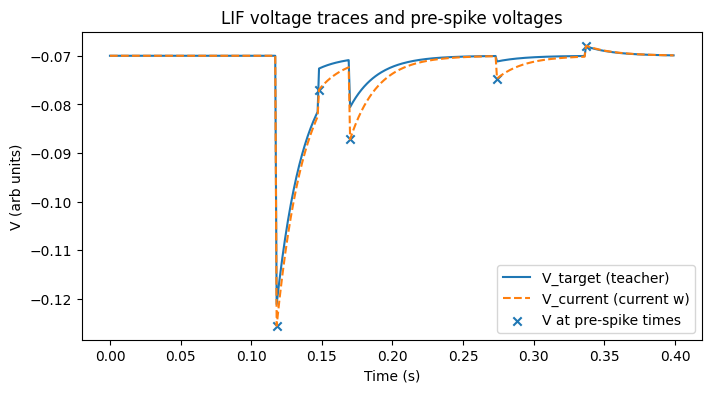

In [ ]:
# Run one example trial
key_master, key_trial = jax.random.split(key_master)
trial = run_single_trial(key_trial, w_true, dt, tau_m, R, V_rest, V0)

print("Loss:", float(trial["loss"]))
print("Current weights:", trial["w_current"])
print("Gradient dL/dw:", trial["grad_w"])

V_target = jnp.array(trial["V_target"])
V_current = jnp.array(trial["V_current"])
t_pre = jnp.array(trial["t_pre"])

plt.figure(figsize=(8, 4))
plt.plot(time, V_target, label="V_target (teacher)")
plt.plot(time, V_current, "--", label="V_current (current w)")
plt.scatter(time[t_pre], V_current[t_pre], marker="x", label="V at pre-spike times")
plt.xlabel("Time (s)")
plt.ylabel("V)")
plt.legend()
plt.title("LIF voltage traces and pre-spike voltages")
plt.show()


In [15]:
n_trials = 200

proxy_list = []
grad_list = []

keys = jax.random.split(key_master, n_trials)

for k in keys:
    trial = run_single_trial(k, w_true, dt, tau_m, R, V_rest, V0)
    proxy_list.append(trial["local_v"])   # shape (n_syn,)
    grad_list.append(trial["grad_w"])     # shape (n_syn,)

proxy_all = jnp.concatenate(proxy_list, axis=0)  # shape (n_trials * n_syn,)
grad_all = jnp.concatenate(grad_list, axis=0)

corr_mat = jnp.corrcoef(proxy_all, grad_all)
corr = float(corr_mat[0, 1])
print("Correlation between V(t_pre) and dL/dw:", corr)


Correlation between V(t_pre) and dL/dw: 0.26310575646196754


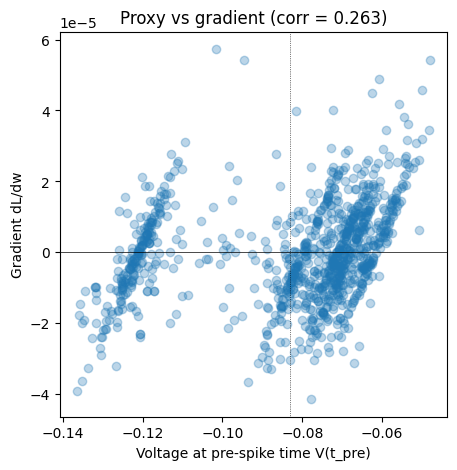

In [16]:
plt.figure(figsize=(5, 5))
plt.scatter(proxy_all, grad_all, alpha=0.3)
plt.xlabel("Voltage at pre-spike time V(t_pre)")
plt.ylabel("Gradient dL/dw")
plt.title(f"Proxy vs gradient (corr = {corr:.3f})")
plt.axhline(0, color="k", linewidth=0.5)
plt.axvline(float(proxy_all.mean()), color="k", linewidth=0.5, linestyle=":")
plt.show()
